In [1]:
# Decision Tree trained on on raw data, and tested on raw data. 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import make_scorer, accuracy_score
from tqdm import tqdm
from typing import Union
import re
import warnings
warnings.filterwarnings('ignore')

## Utility functions

# Visualising the UCI and custom datasets

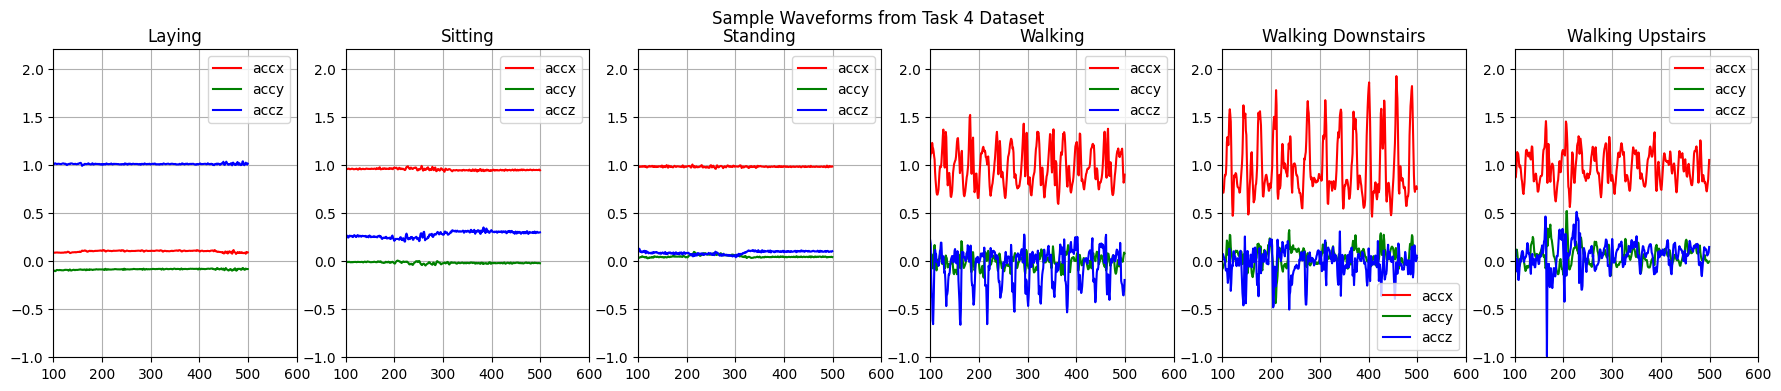

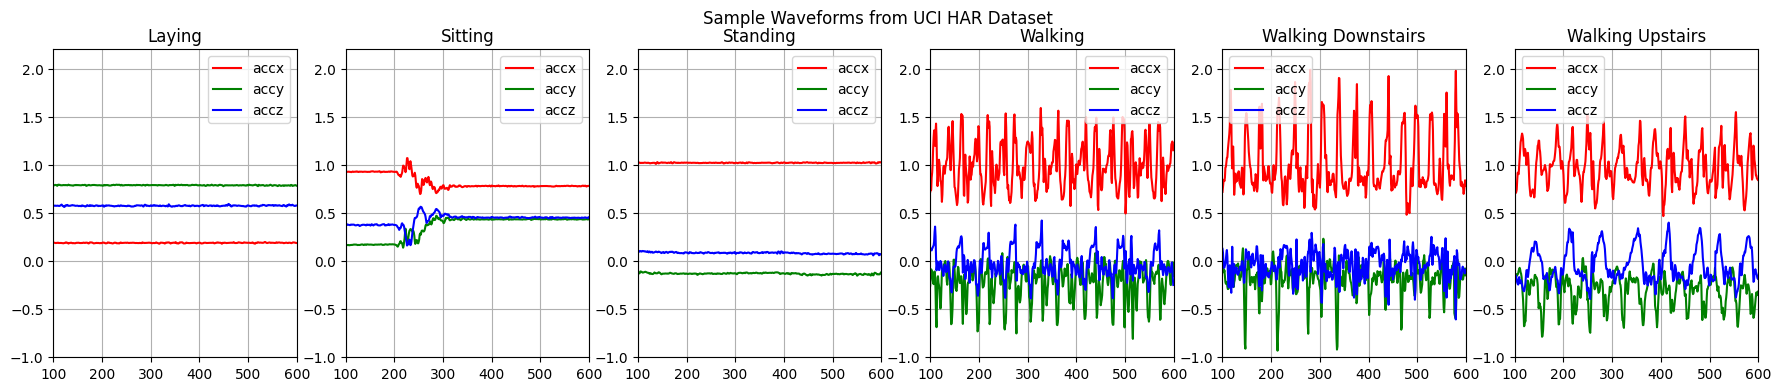

In [23]:
import os
import pandas as pd
import matplotlib.pyplot as plt

activity_classes = ["LAYING", "SITTING", "STANDING", "WALKING", "WALKING_DOWNSTAIRS", "WALKING_UPSTAIRS"]

# Utility Function to load and plot data
def get_sample_data(path, files_per_activity=-1):
    sample_data = []
    for activity_class in activity_classes:
        subpath = os.path.join(path, activity_class)
        files = os.listdir(subpath)
        num_files = len(files) if files_per_activity == -1 else files_per_activity
        for file in range(num_files):
            sample_data.append(os.path.join(subpath, files[file]))
    return sample_data

def plot_waveforms(sample_data, titles, plot_title):
    # Create a figure with 6 subplots
    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(22, 4))
    fig.suptitle(plot_title)

    # Load the data for each sample and plot it
    dfs = [pd.read_csv(sample).iloc[100:600, :] for sample in sample_data]

    for i, ax in enumerate((ax1, ax2, ax3, ax4, ax5, ax6)):
        ax.set_title(titles[i])
        ax.set_ylim([-1, 2.2])
        ax.set_xlim([100, 600])
        ax.plot(dfs[i]['accx'], color='r', label='accx')
        ax.plot(dfs[i]['accy'], color='g', label='accy')
        ax.plot(dfs[i]['accz'], color='b', label='accz')
        ax.legend()
        ax.grid(True)  # Add grid to the plot

    plt.show()

# First Plot: Data from "Datasets/task4_datacollection/raw_dataset/Train"
sample_data1 = get_sample_data(os.path.join("Datasets", 'task4_datacollection', 'raw_dataset', 'Train'), 1)
titles1 = [sample.split('\\')[4].title().replace('_', ' ') for sample in sample_data1]
plot_waveforms(sample_data1, titles1, "Sample Waveforms from Task 4 Dataset")

# Second Plot: Data from "Datasets/Combined/Train"
sample_data2 = get_sample_data(os.path.join("Datasets", 'Combined', 'Train'), 1)
titles2 = [sample.split('\\')[3].title().replace('_', ' ') for sample in sample_data2]
plot_waveforms(sample_data2, titles2, "Sample Waveforms from UCI HAR Dataset")


# Training on UCI HAR raw data, testing on custom data

In [2]:
from MakeDataset import X_train, y_train
from MakeTask4Dataset import X as X_test, y as y_test
classes = {1:"WALKING", 2:"WALKING_UPSTAIRS", 3:"WALKING_DOWNSTAIRS", 4:"SITTING", 5:"STANDING", 6:"LAYING"}

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (126, 1500)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Shape: (54, 1500)

print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")

X_train shape: (126, 500, 3)
X_test shape: (72, 500, 3)
y_train shape: (126,)
y_test shape: (72,)
X_train_flat shape: (126, 1500)
X_test_flat shape: (72, 1500)


In [3]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_flat, y_train)
y_pred = clf.predict(X_test_flat)
print("Decision Tree Hyperparameters:\n", clf.get_params(), "\n")

Decision Tree Hyperparameters:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 0, 'splitter': 'best'} 



In [4]:
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=[classes[i] for i in sorted(classes.keys())]))

precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)

print("Precision, Recall, and Accuracy for each class:")
for i, class_label in enumerate(sorted(classes.keys())):
    class_accuracy = accuracy_score(y_test == class_label, y_pred == class_label)
    print(f"Class {classes[class_label]}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, Accuracy = {class_accuracy:.4f}")

precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

print(f"\nOverall Precision (Macro-averaged): {precision_macro}")
print(f"Overall Recall (Macro-averaged): {recall_macro}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy}")


Classification Report:
                     precision    recall  f1-score   support

           WALKING       0.29      0.17      0.21        12
  WALKING_UPSTAIRS       0.00      0.00      0.00        12
WALKING_DOWNSTAIRS       0.33      0.58      0.42        12
           SITTING       0.07      0.17      0.10        12
          STANDING       1.00      0.17      0.29        12
            LAYING       1.00      1.00      1.00        12

          accuracy                           0.35        72
         macro avg       0.45      0.35      0.34        72
      weighted avg       0.45      0.35      0.34        72

Precision, Recall, and Accuracy for each class:
Class WALKING: Precision = 0.2857, Recall = 0.1667, Accuracy = 0.7917
Class WALKING_UPSTAIRS: Precision = 0.0000, Recall = 0.0000, Accuracy = 0.8333
Class WALKING_DOWNSTAIRS: Precision = 0.3333, Recall = 0.5833, Accuracy = 0.7361
Class SITTING: Precision = 0.0667, Recall = 0.1667, Accuracy = 0.4722
Class STANDING: Precision

c:\Users\yashk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yashk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yashk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

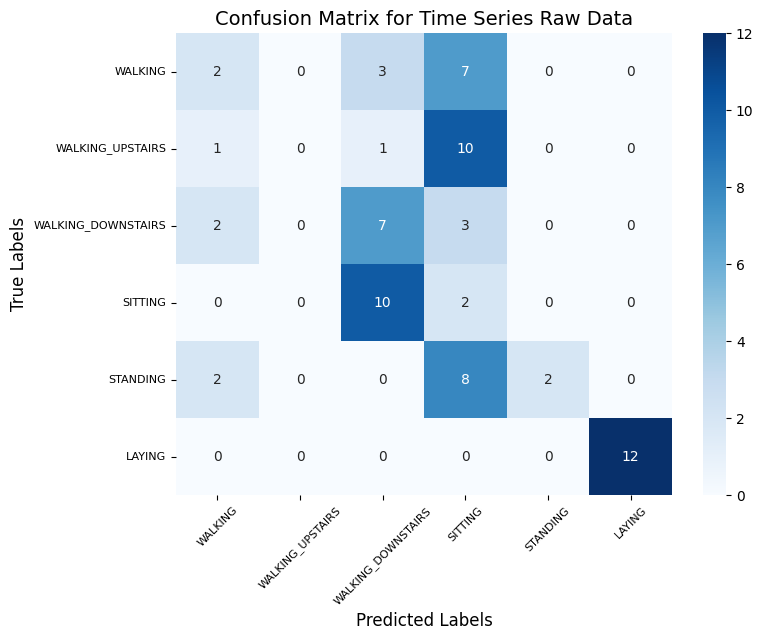

In [5]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[classes[i] for i in sorted(classes.keys())], 
            yticklabels=[classes[i] for i in sorted(classes.keys())])

plt.xticks(fontsize=8, rotation=45)  
plt.yticks(fontsize=8)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix for Time Series Raw Data', fontsize=14)

plt.show()


# Training on filtered UCI HAR TSFEL features, testing on custom data

X_train shape: (126, 1, 1173)
y_train shape: (126,)
X_test shape: (48, 1, 1173)
y_test shape: (48,)
X_train_flat shape: (126, 1173)
X_test_flat shape: (48, 1173)
X_train shape: (126, 1, 1173)
X_test shape: (48, 1, 1173)
y_train shape: (126,)
y_test shape: (48,)
X_train_flat shape: (126, 1173)
X_test_flat shape: (48, 1173)
Decision Tree Hyperparameters:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 0, 'splitter': 'best'} 

Classification Report:
                     precision    recall  f1-score   support

           WALKING       1.00      1.00      1.00         8
  WALKING_UPSTAIRS       0.50      0.62      0.56         8
WALKING_DOWNSTAIRS       0.60      0.38      0.46         8
           SITTING       0.00      0.00      0.00         8
          STANDING

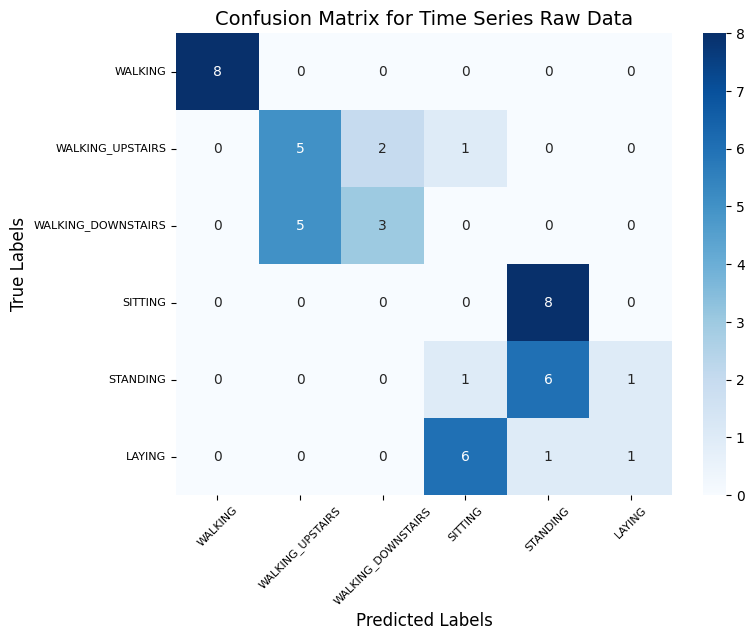

In [25]:
def load_tsfel_dataset(base_dir, dataset_type):
    activities = ['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

    data = []
    labels = []
    
    for activity in activities:
        folder_path = os.path.join(base_dir, dataset_type, activity)
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(folder_path, file_name)
                df = pd.read_csv(file_path)
                
                num_timesteps, num_features = df.shape
                
                subject_data = df.values.reshape((num_timesteps, num_features))  # Shape: (500, 3)
                
                data.append(subject_data)
                labels.append(activity)
    
    data = np.array(data)  # Shape: (num_subjects, num_timesteps, num_features)
    labels = np.array(labels) 
    
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    
    return data, labels_encoded

base_dir1 = 'Datasets/TSFEL_3axes_allfeatures'  
base_dir2 = 'Datasets/task4_datacollection/TSFEL_dataset'
X_train, y_train = load_tsfel_dataset(base_dir1, 'Train')
X_test, y_test = load_tsfel_dataset(base_dir2, 'Train')

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (126, 1500)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Shape: (54, 1500)

print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (126, 1500)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Shape: (54, 1500)

print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")

clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_flat, y_train)
y_pred = clf.predict(X_test_flat)
print("Decision Tree Hyperparameters:\n", clf.get_params(), "\n")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=[classes[i] for i in sorted(classes.keys())]))

precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)

print("Precision, Recall, and Accuracy for each class:")
for i, class_label in enumerate(sorted(classes.keys())):
    class_accuracy = accuracy_score(y_test == class_label, y_pred == class_label)
    print(f"Class {classes[class_label]}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, Accuracy = {class_accuracy:.4f}")

precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

print(f"\nOverall Precision (Macro-averaged): {precision_macro}")
print(f"Overall Recall (Macro-averaged): {recall_macro}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy}")

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[classes[i] for i in sorted(classes.keys())], 
            yticklabels=[classes[i] for i in sorted(classes.keys())])

plt.xticks(fontsize=8, rotation=45)  
plt.yticks(fontsize=8)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix for Time Series Raw Data', fontsize=14)

plt.show()



# Training on raw data: first 2 subjects of custom dataset, testing on the third subject of custom dataset

X_train shape: (48, 500, 3)
X_test shape: (24, 500, 3)
y_train shape: (48,)
y_test shape: (24,)
X_train_flat shape: (48, 1500)
X_test_flat shape: (24, 1500)
Decision Tree Hyperparameters:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 0, 'splitter': 'best'} 

Classification Report:
                     precision    recall  f1-score   support

           WALKING       0.33      0.50      0.40         4
  WALKING_UPSTAIRS       0.50      0.25      0.33         4
WALKING_DOWNSTAIRS       0.75      0.75      0.75         4
           SITTING       0.25      0.25      0.25         4
          STANDING       1.00      1.00      1.00         4
            LAYING       1.00      1.00      1.00         4

          accuracy                           0.62        24
    

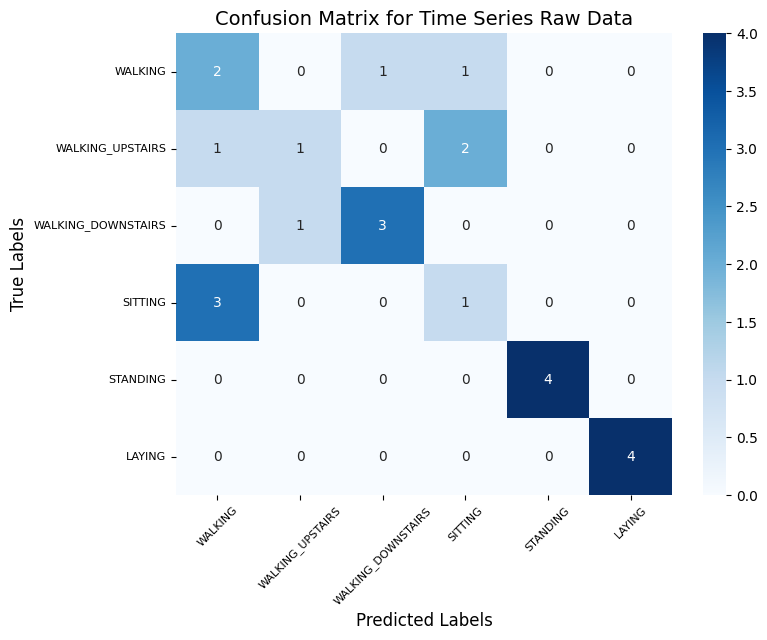

In [27]:
from MakeTask4Dataset import X_train, y_train, X_test, y_test
classes = {1:"WALKING", 2:"WALKING_UPSTAIRS", 3:"WALKING_DOWNSTAIRS", 4:"SITTING", 5:"STANDING", 6:"LAYING"}

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (126, 1500)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Shape: (54, 1500)

print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")

clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_flat, y_train)
y_pred = clf.predict(X_test_flat)
print("Decision Tree Hyperparameters:\n", clf.get_params(), "\n")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=[classes[i] for i in sorted(classes.keys())]))

precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)

print("Precision, Recall, and Accuracy for each class:")
for i, class_label in enumerate(sorted(classes.keys())):
    class_accuracy = accuracy_score(y_test == class_label, y_pred == class_label)
    print(f"Class {classes[class_label]}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, Accuracy = {class_accuracy:.4f}")

precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

print(f"\nOverall Precision (Macro-averaged): {precision_macro}")
print(f"Overall Recall (Macro-averaged): {recall_macro}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy}")

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[classes[i] for i in sorted(classes.keys())], 
            yticklabels=[classes[i] for i in sorted(classes.keys())])

plt.xticks(fontsize=8, rotation=45)  
plt.yticks(fontsize=8)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix for Time Series Raw Data', fontsize=14)

plt.show()



# Training on filtered TSFEL data: first 2 subjects of custom dataset, testing on the third subject of custom dataset

X_train shape: (48, 1, 1173)
y_train shape: (48,)
X_test shape: (24, 1, 1173)
y_test shape: (24,)
X_train_flat shape: (48, 1173)
X_test_flat shape: (24, 1173)
X_train shape: (48, 1, 1173)
X_test shape: (24, 1, 1173)
y_train shape: (48,)
y_test shape: (24,)
X_train_flat shape: (48, 1173)
X_test_flat shape: (24, 1173)
Decision Tree Hyperparameters:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 0, 'splitter': 'best'} 

Classification Report:
                     precision    recall  f1-score   support

           WALKING       1.00      1.00      1.00         4
  WALKING_UPSTAIRS       1.00      1.00      1.00         4
WALKING_DOWNSTAIRS       1.00      1.00      1.00         4
           SITTING       1.00      0.50      0.67         4
          STANDING      

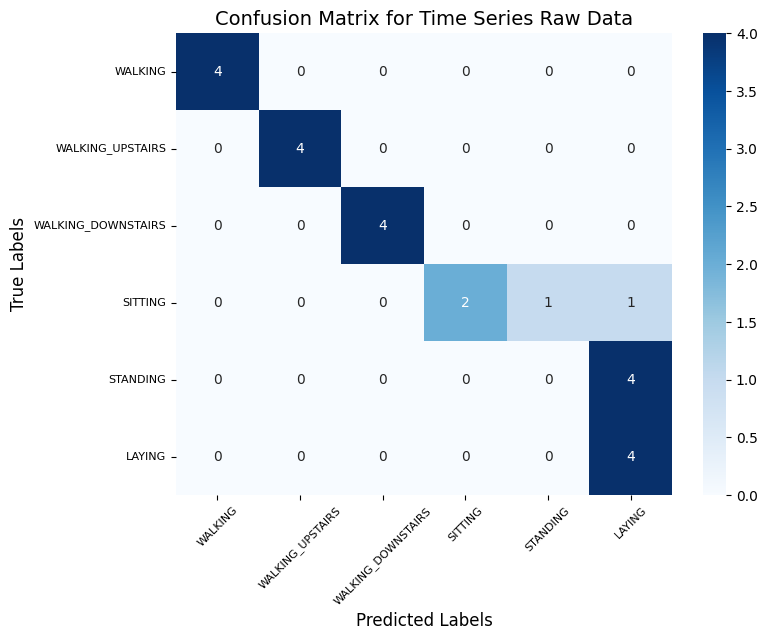

In [30]:
def load_tsfel_dataset(base_dir, dataset_type):
    activities = ['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

    data = []
    labels = []
    
    for activity in activities:
        folder_path = os.path.join(base_dir, dataset_type, activity)
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(folder_path, file_name)
                df = pd.read_csv(file_path)
                
                num_timesteps, num_features = df.shape
                
                subject_data = df.values.reshape((num_timesteps, num_features))  # Shape: (500, 3)
                
                data.append(subject_data)
                labels.append(activity)
    
    data = np.array(data)  # Shape: (num_subjects, num_timesteps, num_features)
    labels = np.array(labels) 
    
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    
    return data, labels_encoded

base_dir = 'Datasets/task4_datacollection/TSFEL_dataset'  
X_train, y_train = load_tsfel_dataset(base_dir, 'Train')
X_test, y_test = load_tsfel_dataset(base_dir, 'Test')

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (126, 1500)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Shape: (54, 1500)

print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (126, 1500)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Shape: (54, 1500)

print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")

clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_flat, y_train)
y_pred = clf.predict(X_test_flat)
print("Decision Tree Hyperparameters:\n", clf.get_params(), "\n")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=[classes[i] for i in sorted(classes.keys())]))

precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)

print("Precision, Recall, and Accuracy for each class:")
for i, class_label in enumerate(sorted(classes.keys())):
    class_accuracy = accuracy_score(y_test == class_label, y_pred == class_label)
    print(f"Class {classes[class_label]}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, Accuracy = {class_accuracy:.4f}")

precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

print(f"\nOverall Precision (Macro-averaged): {precision_macro}")
print(f"Overall Recall (Macro-averaged): {recall_macro}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy}")

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[classes[i] for i in sorted(classes.keys())], 
            yticklabels=[classes[i] for i in sorted(classes.keys())])

plt.xticks(fontsize=8, rotation=45)  
plt.yticks(fontsize=8)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix for Time Series Raw Data', fontsize=14)

plt.show()



In [2]:
class Example:
    def __init__(self, data: Union[pd.DataFrame, None], classification: Union[str, None], modify=False, precision=None):
        self.data = self.modify_data(data, precision) if modify else data
        self.classification = classification
        self.text = self.format_data_to_string(self.data)

    @staticmethod
    def modify_data(data: Union[pd.DataFrame, None], precision=None):
        data = data.round(precision if precision is not None else 0) if data is not None else data
        return data
    
    @staticmethod
    def format_data_to_string(data: Union[pd.DataFrame, None]) -> str:
        if data is not None:
            array = data.to_numpy()
            array_str = np.array2string(array, separator=',', threshold=np.inf, max_line_width=np.inf)
            formatted_str = re.sub(r'[\[\]]', '', array_str).replace(' ', '')
            return formatted_str
        return ''

In [3]:
from MakeDataset import X, y

activity_classes = ["LAYING", "SITTING", "STANDING", "WALKING", "WALKING_DOWNSTAIRS", "WALKING_UPSTAIRS"]
titles = [activity_class.replace('_', ' ').title() for activity_class in activity_classes]
X = [pd.DataFrame(df, columns=['accx', 'accy', 'accz']).iloc[235:265, :].reset_index(drop=True) for df in X]
sampled_indices = list(range(0, 125, 21)) + list(range(1, 125, 21)) + list(range(2, 125, 21)) + list(range(3, 125, 21))
uci_examples = []

for sampled_index in sampled_indices:
    uci_examples.append(Example(X[sampled_index], titles[int(y[sampled_index]) - 1], True, 3))
    print(titles[int(y[sampled_index]) - 1])

Walking Upstairs
Walking
Walking Downstairs
Laying
Standing
Sitting
Walking Upstairs
Walking
Walking Downstairs
Laying
Standing
Sitting
Walking Upstairs
Walking
Walking Downstairs
Laying
Standing
Sitting
Walking Upstairs
Walking
Walking Downstairs
Laying
Standing
Sitting


In [4]:
dir = r'C:\Users\Nishchay\Desktop\College\ES 335 Machine Learning\Assignments\es335-24-fall-assignment-1\Datasets\task4_datacollection\raw_dataset'

X_train, y_train, X_test, y_test = [], [], [], []
training_examples = []
testing_examples = []

def load_custom_data(data_type):
    data = []
    labels = []    
    for activity_class in activity_classes:
        activity_folder = os.path.join(dir, data_type, activity_class)        
        for file_name in os.listdir(activity_folder):
            if file_name.endswith('.csv'):
                df = pd.read_csv(os.path.join(activity_folder, file_name))
                df = pd.DataFrame(df, columns=['accx', 'accy', 'accz']).iloc[235:265, :].reset_index(drop=True)
                data.append(df)
                labels.append(activity_class)
    
    return data, labels

X_train, y_train = load_custom_data('Train')
X_test, y_test = load_custom_data('Test')

for df, label in zip(X_train, y_train):
    training_examples.append(Example(df, label.replace('_', ' ').title(), True, 3))

for df, label in zip(X_test, y_test):
    testing_examples.append(Example(df, label.replace('_', ' ').title(), True, 3))

combined_examples = training_examples.copy()
combined_examples.extend(testing_examples)

In [5]:
from langchain_groq.chat_models import ChatGroq
from dotenv import load_dotenv

load_dotenv()
groq_models = {"llama-3.1-8b-instant": "llama-3.1-8b-instant", "llama-3.1-70b-versatile": "llama-3.1-70b-versatile", "llama3-70b": "llama3-70b-8192", "mixtral": "mixtral-8x7b-32768", "gemma-7b": "gemma-7b-it","llama3.1-70b":"llama-3.1-70b-versatile","llama3-8b":"llama3-8b-8192","llama3.1-8b":"llama-3.1-8b-instant","gemma-9b":"gemma2-9b-it"}

num_api_keys = 12
model_name = "llama-3.1-70b-versatile"

In [6]:
query_str = """You are an expert classifier. You are given some values of the following features of a human, in order:
1. accx: Mean of the body acceleration signal in the X-axis (horizontal movement).
2. accy: Mean of the body acceleration signal in the Y-axis (vertical movement).
3. accz: Mean of the body acceleration signal in the Z-axis (lateral movement).

These values are sampled at a frequency of 50 hz. 

Your task is to classify the activity into one of the following classes: Laying, Sitting, Standing, Walking, Walking Downstairs, Walking Upstairs.

Here are some examples to help you get started:
"""

example_template = """
=======================================================
- Activity:
{activity}

- Classification: {classification}
"""

for example in uci_examples:
    query_str += example_template.format(activity=example.text, classification=example.classification)

ending_str = """
Now classify the below activity. Make sure you limit your response to ONLY your classification, without providing any reasoning or justification for it. If you're not sure, return your best guess. Also, do not add any punctuations. Limit your response to the exact classification and nothing else:

"""

query_str += ending_str

correct = 0
total = 0
cur_example = 0
cur_api_key = 1

while cur_example < len(combined_examples):
    try:
        llm = ChatGroq(model=groq_models[model_name], api_key=os.environ[f'API_KEY_{cur_api_key}'], temperature=0)
        response = llm.invoke(query_str + combined_examples[cur_example].text).content.strip()
        print(response)
        print(combined_examples[cur_example].classification)
        print()

        if response == combined_examples[cur_example].classification:
            correct += 1
        total += 1
        cur_example += 1
    except:
        cur_api_key = (cur_api_key % num_api_keys) + 1 

accuracy = correct / total
accuracy *= 100
print(f'Accuracy: {accuracy:.2f}%')

Walking Upstairs
Laying

Walking Upstairs
Laying

Walking Upstairs
Laying

Laying
Laying

Walking Upstairs
Laying

Walking Upstairs
Laying

Walking Upstairs
Laying

Walking Upstairs
Laying

Walking
Sitting

Walking
Sitting

Walking
Sitting

Walking Upstairs
Sitting

Walking Upstairs
Sitting

Walking Upstairs
Sitting

Walking Upstairs
Sitting

Walking Upstairs
Sitting

Walking
Standing

Sitting
Standing

Sitting
Standing

Walking
Standing

Walking
Standing

Walking
Standing

Walking
Standing

Walking
Standing

Laying
Walking

Laying
Walking

Laying
Walking

Standing
Walking

Laying
Walking

Laying
Walking

Laying
Walking

Laying
Walking

Laying
Walking Downstairs

Laying
Walking Downstairs

Standing
Walking Downstairs

Laying
Walking Downstairs

Walking
Walking Downstairs

Laying
Walking Downstairs

Walking Downstairs
Walking Downstairs

Walking
Walking Downstairs

Walking Downstairs
Walking Upstairs

Walking Downstairs
Walking Upstairs

Standing
Walking Upstairs

Walking Upstairs
Walki

In [12]:
query_str = """You are an expert classifier. You are given some values of the following features of a human, in order:
1. accx: Mean of the body acceleration signal in the X-axis (horizontal movement).
2. accy: Mean of the body acceleration signal in the Y-axis (vertical movement).
3. accz: Mean of the body acceleration signal in the Z-axis (lateral movement).

These values are sampled at a frequency of 50 hz. 

Your task is to classify the activity into one of the following classes: Laying, Sitting, Standing, Walking, Walking Downstairs, Walking Upstairs.

Here are some examples to help you get started:
"""

example_template = """
=======================================================
- Activity:
{activity}

- Classification: {classification}
"""

for example in training_examples:
    query_str += example_template.format(activity=example.text, classification=example.classification)

ending_str = """
Now classify the below activity. Make sure you limit your response to ONLY your classification, without providing any reasoning or justification for it. If you're not sure, return your best guess. Also, do not add any punctuations. Limit your response to the exact classification and nothing else:

"""

query_str += ending_str

correct = 0
total = 0
cur_example = 0
cur_api_key = 1

while cur_example < len(testing_examples):
    try:
        llm = ChatGroq(model=groq_models[model_name], api_key=os.environ[f'API_KEY_{cur_api_key}'], temperature=0)
        response = llm.invoke(query_str + testing_examples[cur_example].text).content.strip()
        print(response)
        print(testing_examples[cur_example].classification)
        print()

        if response == testing_examples[cur_example].classification:
            correct += 1
        total += 1
        cur_example += 1
    except:
        cur_api_key = (cur_api_key % num_api_keys) + 1 

accuracy = correct / total
accuracy *= 100
print(f'Accuracy: {accuracy:.2f}%')

Laying
Laying

Laying
Laying

Laying
Laying

Laying
Laying

Sitting
Sitting

Sitting
Sitting

Sitting
Sitting

Sitting
Sitting

Standing
Standing

Standing
Standing

Standing
Standing

Standing
Standing

Walking Downstairs
Walking

Walking Downstairs
Walking

Walking Downstairs
Walking

Walking Downstairs
Walking

Walking
Walking Downstairs

Walking
Walking Downstairs

Walking
Walking Downstairs

Walking Upstairs
Walking Downstairs

Walking Upstairs
Walking Upstairs

Walking Upstairs
Walking Upstairs

Walking Downstairs
Walking Upstairs

Walking Upstairs
Walking Upstairs

Accuracy: 62.50%


In [7]:
activity_classes = ["LAYING", "SITTING", "STANDING", "WALKING", "WALKING_DOWNSTAIRS", "WALKING_UPSTAIRS"]

def load_csv_files(directory, label, add_timestamp=True, add_total_acc=True, trim_data=True):
    df_list = []
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory, filename)
            df = pd.read_csv(file_path)
            df['subject'] = filename.replace('.csv', '')
            # 50 samples per second
            # 1 sample takes 1/50 seconds
            if add_timestamp:
                df['timestamp'] = (df.index + 1) / 50
            if add_total_acc:
                df['total_acc'] = df['accx'] ** 2 + df['accy'] ** 2 + df['accz'] ** 2
            if trim_data:
                df_list.append(df.iloc[100:600, :])
            else:
                df_list.append(df)
    combined_df = pd.concat(df_list, ignore_index=True)
    combined_df['y'] = label
    return combined_df

def get_tsfel_features(tsfel_features_path):   
    data = pd.DataFrame()
    for label, activity_class in enumerate(activity_classes):
        folder_path = os.path.join(tsfel_features_path, activity_class)
        dfs = load_csv_files(folder_path, label, False, False, False)
        data = pd.concat([data, dfs], axis=0, ignore_index=True)
    return data

def get_tsfel_feat():
	all_data = get_tsfel_features(r'Datasets\TSFEL_3axes_filteredfeatures\Train')
	X_train = all_data.drop(columns=['y', 'subject'])
	X_train = [X_train.iloc[i, :] for i in range(X_train.shape[0])]
	y_train = list(all_data['y'].values)
	y_train = [activity_classes[i] for i in y_train]
 
	all_data = get_tsfel_features(r'Datasets\TSFEL_3axes_filteredfeatures\Test')
	X_test = all_data.drop(columns=['y', 'subject'])
	X_test = [X_test.iloc[i, :] for i in range(X_test.shape[0])]
	y_test = list(all_data['y'].values)
	y_test = [activity_classes[i] for i in y_test]
 
	return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = get_tsfel_feat()

[accx_Absolute energy                     1.778570e+01
 accx_Area under the curve                1.882075e+00
 accx_Average power                       1.782134e+00
 accx_ECDF Percentile Count_0             1.000000e+02
 accx_ECDF Percentile Count_1             4.000000e+02
 accx_FFT mean coefficient_89             7.952699e-08
 accx_LPCC_8                              8.882150e-01
 accx_Lempel-Ziv complexity               1.700000e-01
 accx_MFCC_1                             -4.467616e-01
 accx_MFCC_10                            -1.198179e+01
 accx_MFCC_11                             5.065779e+00
 accx_MFCC_3                             -3.850589e+00
 accx_MFCC_5                              1.824562e-01
 accx_MFCC_8                              5.970042e+00
 accx_Maximum fractal length              8.168558e-02
 accx_Mean absolute diff                  1.450267e-03
 accx_Median frequency                    0.000000e+00
 accx_Signal distance                     4.990009e+02
 accx_Skew